# Compile analysis

first we list all the relevant result files

In [1]:
from astropy.time import Time, TimeDelta
import h5py
import numpy as np
import pickle
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')

import sorts
import pyorb
import pyant

In [2]:
HERE = Path('.').resolve()
OUTPUT = HERE / 'output' / 'russian_asat'
print(f'Using {OUTPUT} as output')

Using /home/danielk/git/antisat_analysis/projects/output/russian_asat as output


In [3]:
with open(OUTPUT / 'paths.pickle', 'rb') as fh:
    paths = paths = pickle.load(fh)

pprint(paths)

{'correlation_select': {'esr': [PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.19_esr_correlation_plots/eiscat_esr_selected_correlations.npy'),
                                PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.23_esr_correlation_plots/eiscat_esr_selected_correlations.npy'),
                                PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.25_esr_correlation_plots/eiscat_esr_selected_correlations.npy'),
                                PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.29_esr_correlation_plots/eiscat_esr_selected_correlations.npy')],
                        'uhf': [PosixPath('/home/danielk/git/antisat_analysis/projects/output/russian_asat/2021.11.23_uhf_correlation_plots/eiscat_uhf_selected_correlations.npy'),
                                PosixPath('/home/danielk/git/antisat_analysis/projects/output/russi

## Compile kosmos-1408 list

first we devide the results into 4 categores:
```
uncorrelated results
| - possible kosmos fragments
| - not kosmos fragments
correlated results
| - kosmos fragments
| - not kosmos fragments
```

To do this we need selection criteria for "possible kosmos fragments" for each campagin

In [4]:
class Categories:
    uncorrelated_other = 0
    correlated_other = 1
    uncorrelated_kosmos = 2
    correlated_kosmos = 3
category_names = [
    'Uncorrelated background',
    'Correlated background',
    'Uncorrelated KOSMOS-1408',
    'Correlated KOSMOS-1408',
]

### Category selection
We can then select these categories, we start by loading the relevant data

In [5]:
def calculate_categories(radar, date_ind, kosmos_selection):
    data = {}
    with h5py.File(paths['data_paths'][radar][date_ind], 'r') as hf:
        for key in hf:
            data[key] = hf[key][()]
    select = np.load(paths['correlation_select'][radar][date_ind])
    kosmos_select = np.load(paths['kosmos_correlation_select'][radar][date_ind])
    date = paths['data_paths'][radar][date_ind].stem.replace('.', '-')
    
    # The category identifier
    category = np.full((len(data['t'],)), Categories.uncorrelated_other, dtype=int)

    #get data
    r_box = kosmos_selection[radar]['r']

    t = (data['t'] - np.min(data['t']))/3600.0
    r = data['r']
    v = data['v']
    box_selectors = []
    t_boxes = []
    v_boxes = []
    for t_box, v_box in zip(
                kosmos_selection[radar]['t'][date_ind],
                kosmos_selection[radar]['v'][date_ind]
            ):
        t_boxes.append(t_box)
        v_boxes.append(v_box)
        box_selectors += [np.logical_and.reduce([
            t >= t_box[0], 
            t <= t_box[1],
            r >= r_box[0], 
            r <= r_box[1],
            v >= v_box[0], 
            v <= v_box[1],
        ])]
    box_selector = np.logical_or.reduce(box_selectors)

    # Assign categories
    category[:] = Categories.uncorrelated_other
    category[box_selector] = Categories.uncorrelated_kosmos
    category[select] = Categories.correlated_other
    category[kosmos_select] = Categories.correlated_kosmos
    
    out_categories = OUTPUT / f'{date}_{radar}_categories.npy'
    np.save(out_categories, category)
    
    return category, t_boxes, r_box, v_boxes, t, r, v

In [19]:
#Structure is (lower left corner), (upper right corner)
kosmos_selection = {
    'uhf': {
        'r': (280, 700),
        'v': [
            [(0.2, 1.6), ], 
            [(0.2, 1.6), ], 
            [(0.2, 1.6), (-0.4, 1), ], 
        ],
        't': [
            [(2.5, 3), ],
            [(2.1, 2.6), ],
            [(4.5, 5.2), (19.2, 19.8), ],
        ],
    },
    'esr': {
        'r': (280, 700),
        'v': [
            [(0.3, 1.6), (0.3, 1.6), ], 
            [(0.2, 1.6), ], 
            [(0.2, 1.6), (-0.4, 1), ], 
            [(0.2, 1.6), ], 
        ],
        't': [
            [(9.7, 10.6), (16.6, 17.6)],
            [(2.4, 2.9), ],
            [(4.5, 5.2), (19.2, 19.8), ],
            [(4.5, 5.2), ],
        ],
    },
}

In [22]:
category, t_boxes, r_box, v_boxes, t, r, v = calculate_categories('esr', 1, kosmos_selection)

(-2.5, 2.5)

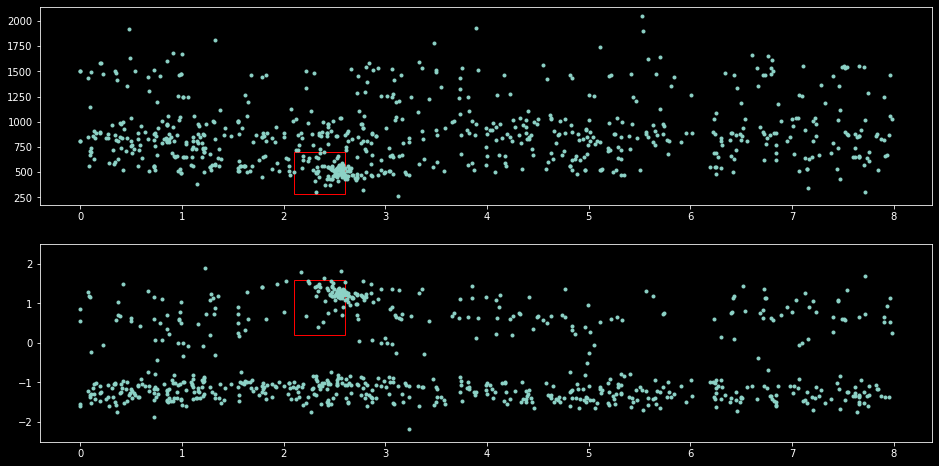

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(16,8))
axes[0].plot(t, r, '.')
for t_box, v_box in zip(t_boxes, v_boxes):
    rect = patches.Rectangle(
        (t_box[0], r_box[0]), 
        t_box[1] - t_box[0], 
        r_box[1] - r_box[0], 
        linewidth=1, 
        edgecolor='r', 
        facecolor='none',
    )
    axes[0].add_patch(rect)

axes[1].plot(t, v, '.')
for t_box, v_box in zip(t_boxes, v_boxes):
    rect = patches.Rectangle(
        (t_box[0], v_box[0]), 
        t_box[1] - t_box[0], 
        v_box[1] - v_box[0], 
        linewidth=1, 
        edgecolor='r', 
        facecolor='none',
    )
    axes[1].add_patch(rect)
axes[1].set_ylim(-2.5, 2.5)

Text(0, 0.5, 'Detections')

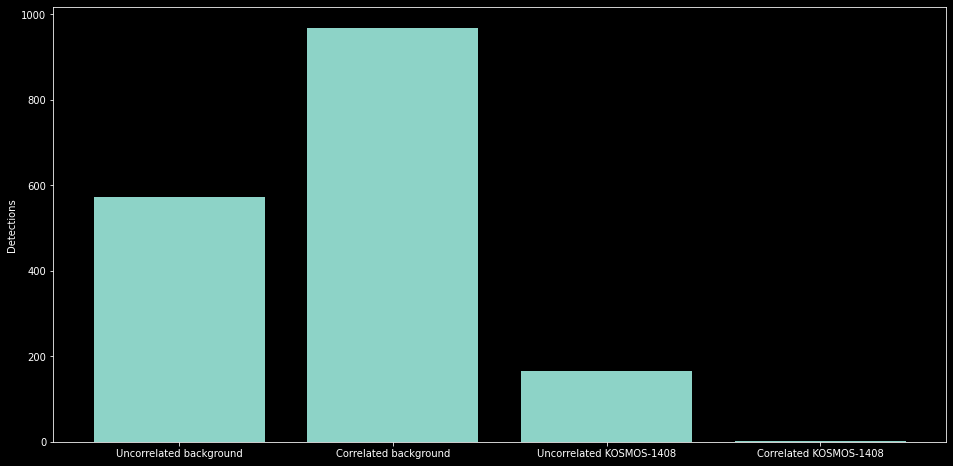

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(4), [np.sum(category == ind) for ind in range(4)])
ax.set_xticks(range(4), labels=category_names)
ax.set_ylabel('Detections')